#### Algorithm walks through the dataset in each plate then:
#### 1. Extract Cell ID, Well, Field Channel, Cycle, Area, Integrated Density for each cell
#### 2. Extract the number of cells in each field and in each well
##### Import Pandas library for reading the dataset from local drive to .csv daframe
##### Import re library for text extraction and processing
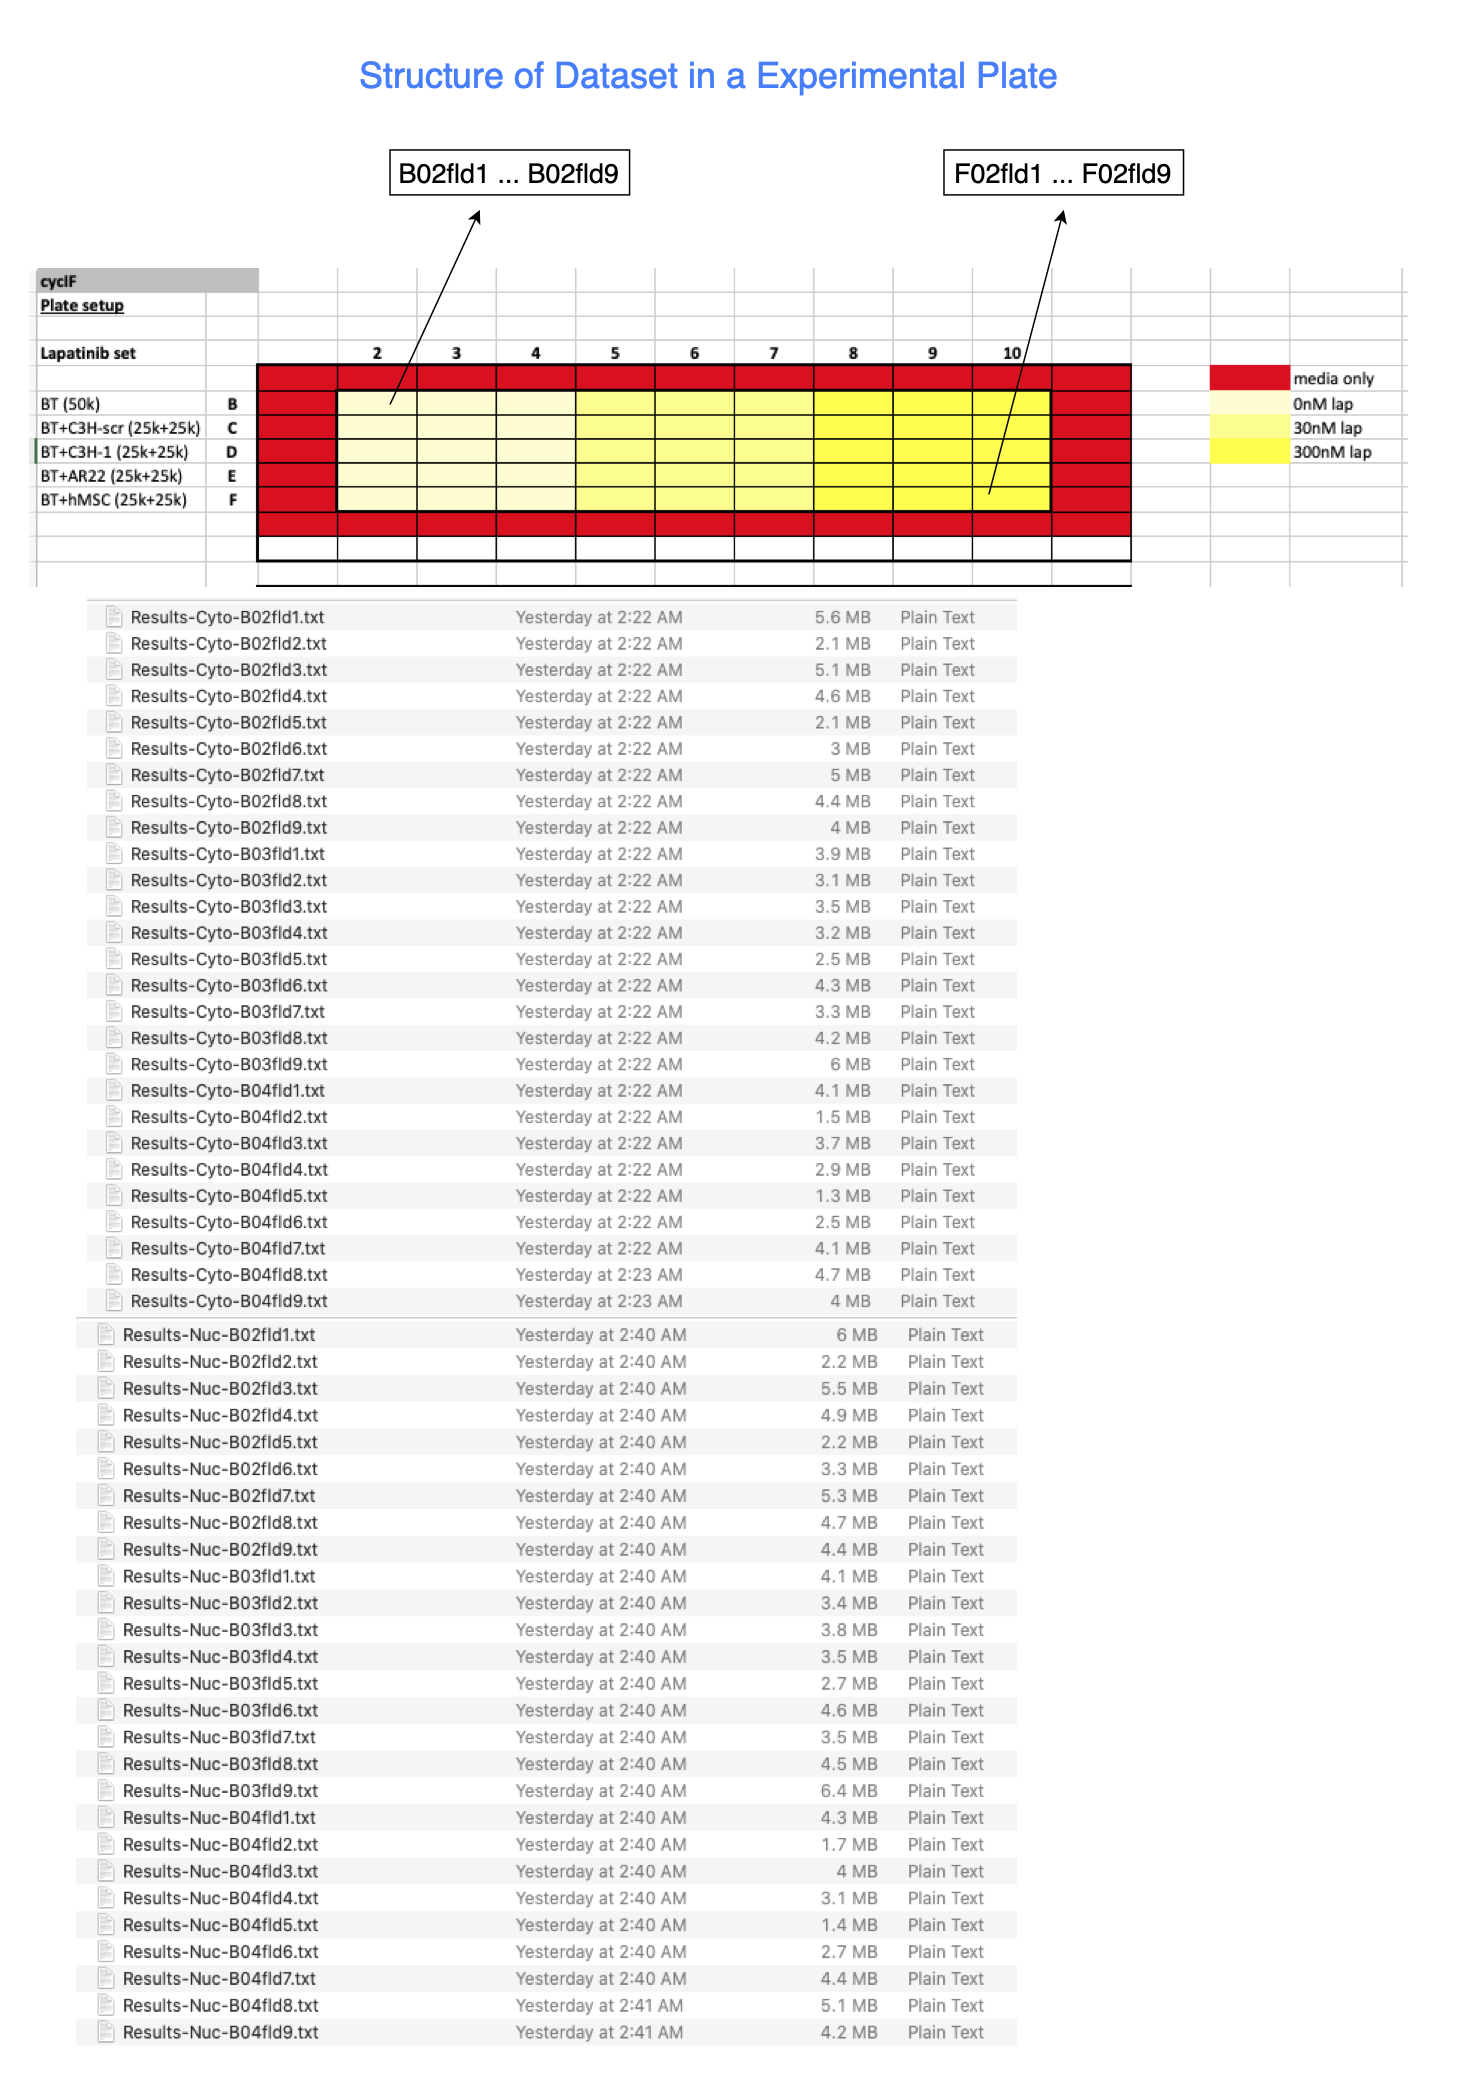

In [1]:
import pandas as pd
import numpy as np
import re

''' Construct the universal Results-Cyto- data file path in local drive named path
    Enter the row and a list of column indice you want to extract data 
    (e.g row E, column indice = [8, 9, 10])
    Construct a list of well IDs: B02-B10 named WELLS
    Construct a list of field IDs: fld1-fld9 named FIELD
'''
path = './052018_plate1/Results-Cyto-'
row, cols = 'B', [3, 6, 9]

WELLS = [row + '0{}'.format(k) for k in cols if k < 10]
if 10 in cols:
    WELLS.append(row + '10')
    
FIELD = ['fld{}'.format(k) for k in range(1, 10)]

''' Construct a list of filenames associated with Cyto in the dataset named files_Cyto
'''
files_Cyto = [path + '{}{}.txt'.format(w, f) 
              for w in WELLS for f in FIELD]

''' Read all Cyto data files in the dataset into a list of dataframes
'''
df_Cyto = [pd.read_csv(file, sep='\t', 
           engine='python', 
           usecols=['Label', 'Area', 'IntDen']) 
           for file in files_Cyto]

''' Double check WELLS, FIELDs that have been processed
    Double check the number of Cyto files that have been read
'''
n = len(df_Cyto)
print(WELLS)
print(FIELD)
print('number of Cyto files that have been read: ', len(df_Cyto))

['B03', 'B06', 'B09']
['fld1', 'fld2', 'fld3', 'fld4', 'fld5', 'fld6', 'fld7', 'fld8', 'fld9']
number of Cyto files that have been read:  27


#### Extract well, field, cell, channel IDs in every entry of all dataframes 
#### Save each of these IDs in Well, Field, Cell ID, Channel columns in the dataframe, respectively
#### Extract Cycle, Area, Integrated Density columns as well

In [2]:
well = r'[A-Z]+.*?(?=_)'
field = r'(?<=d)[\d]{1,1}?(?=:)'
cell_id = r'(\d+)-(\d+)'
channel = r'(?<=:)[A-Z]+.*?(?=-)'

for k in range(len(df_Cyto)):
    df_Cyto[k]['Well'] = df_Cyto[k]['Label'].apply(lambda x: re.search(well, x).group())
    df_Cyto[k]['Field'] = df_Cyto[k]['Label'].apply(lambda x: re.search(field, x).group())
    df_Cyto[k]['Cell ID'] = df_Cyto[k]['Label'].apply(lambda x: re.search(cell_id, x).group())
    df_Cyto[k]['Channel'] = df_Cyto[k]['Label'].apply(lambda x: re.search(channel, x).group())
    df_Cyto[k]['Cycle'] = df_Cyto[k]['Label'].apply(lambda x: int(x[-1]))
    df_Cyto[k] = df_Cyto[k][['Cell ID', 'Well', 'Field', 'Channel', 'Cycle', 'Area', 'IntDen']]

In [3]:
C = []
for df in df_Cyto:
    C.append([df.Well[0], 
             int(df.Field[0]), 
             int(df.shape[0] / df['Cell ID'].value_counts()[0])])

df = pd.DataFrame(C, columns=['Well', 'Field', 'Total Cells'])
df['Row'] = df['Well'].apply(lambda w: w[0])
df['Col'] = df['Well'].apply(lambda w: 10 if w[-1] == '0' else int(w[-1]))
df = df[['Well', 'Row', 'Col', 'Field', 'Total Cells']]

In [4]:
df

,Well,Row,Col,Field,Total Cells
0,B03,B,3,1,655
1,B03,B,3,2,532
2,B03,B,3,3,593
3,B03,B,3,4,546
4,B03,B,3,5,427
5,B03,B,3,6,725
6,B03,B,3,7,559
7,B03,B,3,8,703
8,B03,B,3,9,1009
9,B06,B,6,1,715


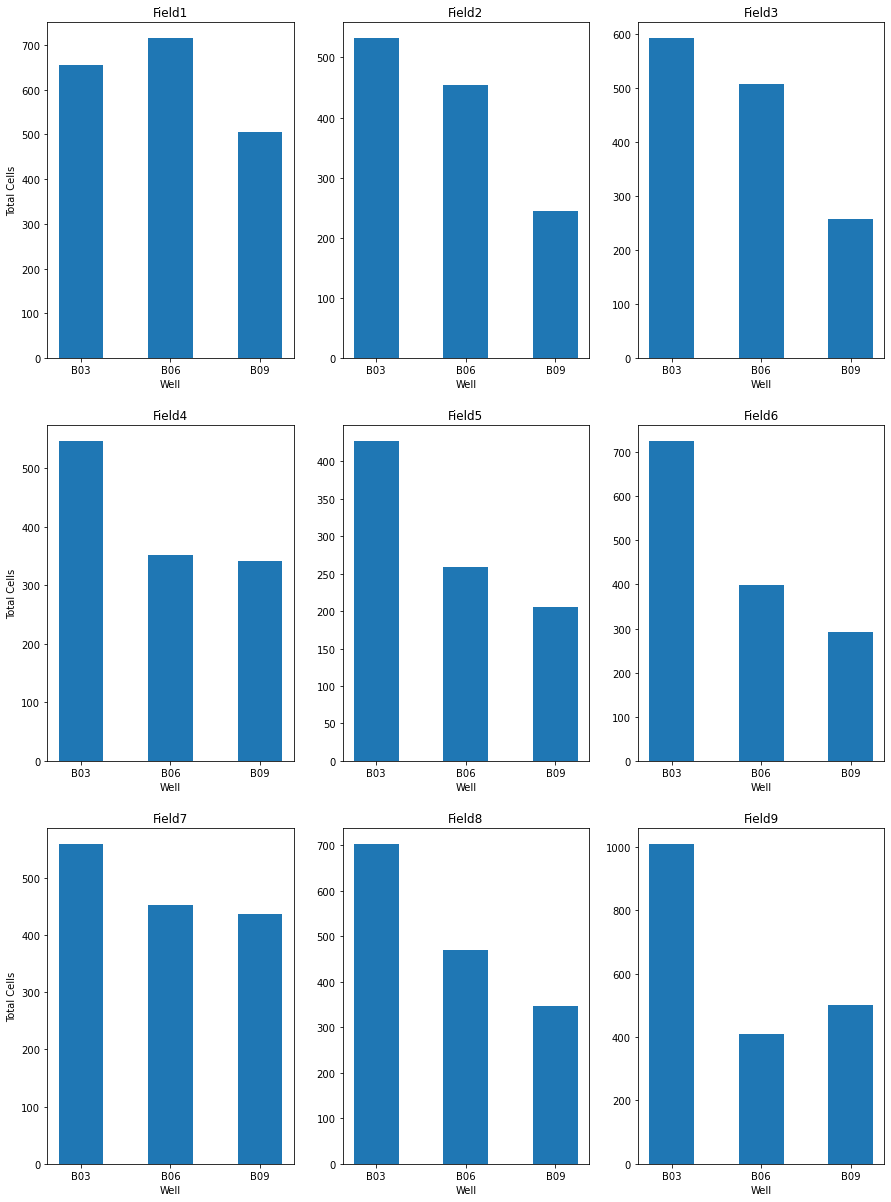

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(15, 21)

for k in range(1, 10):
    df_T = df[df.Field == k]
    ax = axes[(k - 1) // 3][(k - 1) % 3]
    ax.bar(df_T['Well'], df_T['Total Cells'], width=0.5)
    if (k - 1) % 3 == 0:
        ax.set_ylabel('Total Cells')
    ax.set_xlabel('Well')
    ax.set_title('Field{}'.format(k))
plt.show()

#### Visualize how much the cells number change in percentage compare with the previous treatment
#### (e.g. we compare the number of cells at well B06 Field 1 named n6 with B03 Field 1's named n3.
#### the % change of n6 is (n6 - n3) / n3. Similarly, the % change of n9 of B09 Field 1 is (n9 - n3) / n3.)

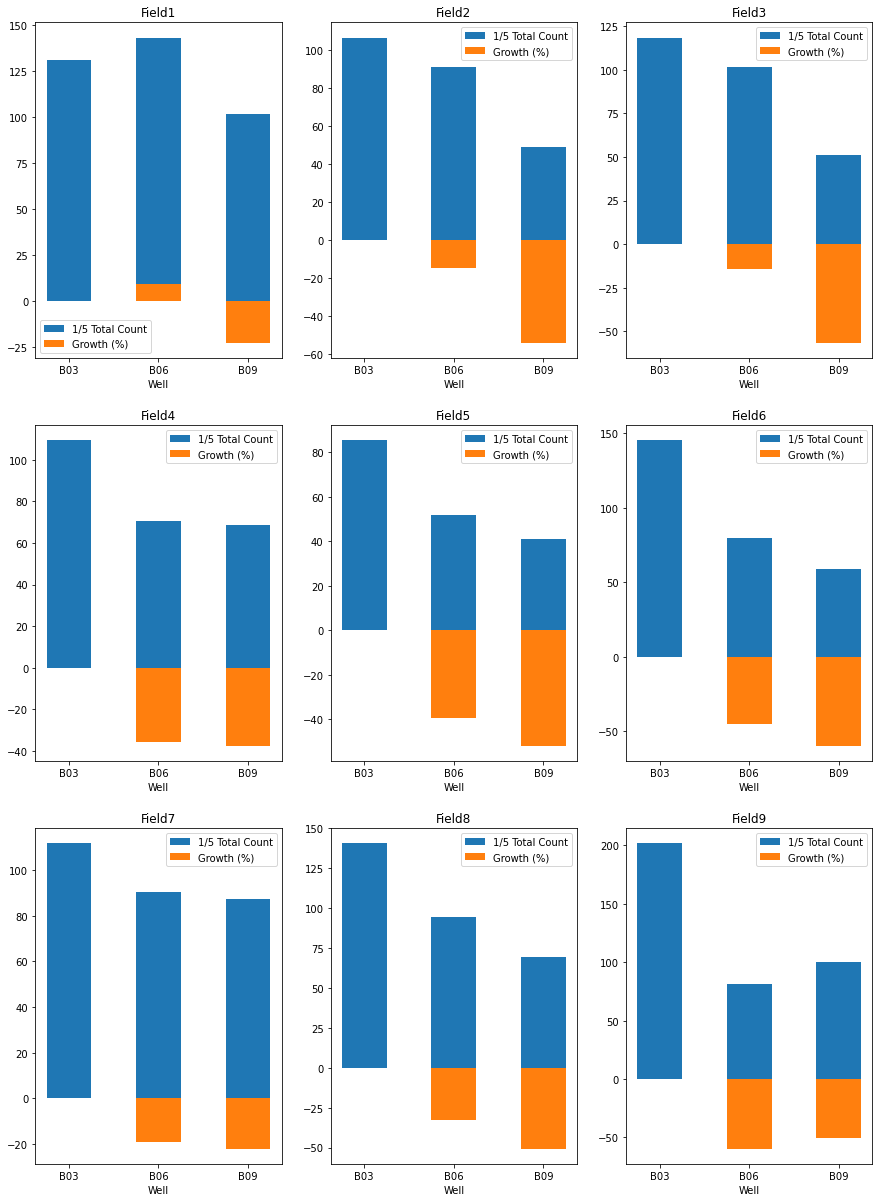

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(15, 21)

for k in range(1, 10):
    df_T = df[df.Field == k].reset_index(drop=True)
    
    n = df_T.at[0, 'Total Cells']
    df_T['# Cells Growth Per.'] = [(df_T.at[j, 'Total Cells'] - n) / n * 100 for j in range(3)]
    
    ax = axes[(k - 1) // 3][(k - 1) % 3]
    ax.bar(df_T['Well'], df_T['Total Cells'] / 5, label='1/5 Total Count', width=0.5)
    ax.bar(df_T['Well'], df_T['# Cells Growth Per.'], label='Growth (%)', width=0.5)
    ax.set_xlabel('Well')
    ax.set_title('Field{}'.format(k))
    ax.legend()
    
plt.show()